In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np 
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
import warnings
warnings.filterwarnings('ignore')

# 데이터셋 로드
train = pd.read_csv('./data/ECG5000/ECG5000_TRAIN.txt', 
                       delim_whitespace=True, header=None)

test = pd.read_csv('./data/ECG5000/ECG5000_TEST.txt', 
                      delim_whitespace=True, header=None)

df = pd.concat([train, test], axis=0)

norm = df[df.iloc[:, 0] == 1].iloc[:, 1:].values
anm = df[df.iloc[:, 0] != 1].iloc[:, 1:].values

### **데이터 전처리**

In [ ]:
# Scaling
scaler = StandardScaler()
norm_scale = scaler.fit_transform(norm)
anm_scale = scaler.transform(anm)

# Tensor 변환
norm_tensor = torch.tensor(norm_scale, dtype=torch.float32)
anm_tensor = torch.tensor(anm_scale, dtype=torch.float32)

# train/test
train_size = int(0.8 * len(norm_tensor))
test_size = len(norm_tensor) - train_size

# DataLoader
# 정상 데이터셋(train/test)
norm_dataset = TensorDataset(norm_tensor, norm_tensor)
train_dataset, test_dataset = random_split(norm_dataset, [train_size, test_size])
norm_train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
norm_test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

anm_dataset = TensorDataset(anm_tensor, anm_tensor)
anm_loader = DataLoader(anm_dataset, batch_size=64, shuffle=True)

### **AutoEncoder 모델 정의**

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self, in_dim):
        super().__init__() 
        
        self.encoder = nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, in_dim),
        )
        
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AutoEncoder(in_dim=140).to(device)

# Loss, Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 100

In [ ]:
for epoch in range(1, epochs + 1):
    
    train_loss = 0.0
    for x, _ in norm_train_loader:
        x = x.to(device)
        
        optimizer.zero_grad()
        outs = model(x)

        loss = criterion(outs, x)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
    train_loss /= len(norm_train_loader)
        
    if epoch % 10 == 0:
        print(f'Epoch [{epoch}/{epochs}], Loss: {train_loss:.4f}')

In [185]:
def compute_loss(loader, model):
    model.eval()
    errors = []
    with torch.no_grad():
        for x, _ in loader:
            x = x.to(device)
            outs = model(x)
            loss = F.mse_loss(outs, x, reduction='none')
            loss = loss.mean(dim = 1)
            
            errors.extend([float(v) for v in loss.cpu().numpy()])
            
            
    return np.array(errors)


norm_errors = compute_loss(norm_test_loader, model)
anm_errors = compute_loss(anm_loader, model)


# 임계값 설정 (예: 정상 재구성 오차의 95% 지점)
threshold = np.percentile(norm_errors, 95)

# 이상치 비율 확인
norm_pred = norm_errors > threshold  # False여야 정상
anm_pred = anm_errors > threshold    # True여야 이상

In [188]:
# True/False 비율 확인
print(f'Normal Data: {np.mean(norm_pred) * 100:.2f}%')
print(f'Anomaly Data: {np.mean(anm_pred) * 100:.2f}%')

Normal Data: 5.14%
Anomaly Data: 95.96%


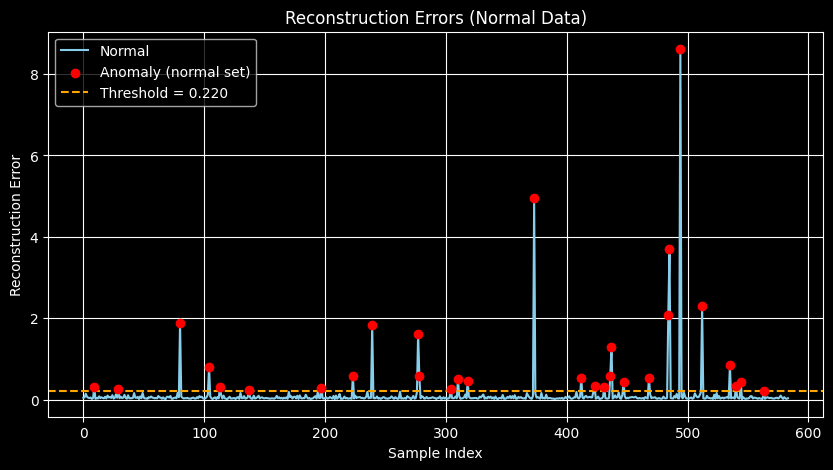

In [204]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

# 정상 데이터: 파란 선
plt.plot(norm_errors, label='Normal', color='skyblue')

# 이상치인 부분만 빨간 점으로 표시
anom_idx = np.where(norm_pred)[0]
plt.scatter(anom_idx, norm_errors[anom_idx], color='red', label='Anomaly (normal set)', zorder=3)

# 임계값 수평선
plt.axhline(threshold, color='orange', linestyle='--', label=f'Threshold = {threshold:.3f}')

plt.title("Reconstruction Errors (Normal Data)")
plt.xlabel("Sample Index")
plt.ylabel("Reconstruction Error")
plt.legend()
plt.grid(True)
plt.show()


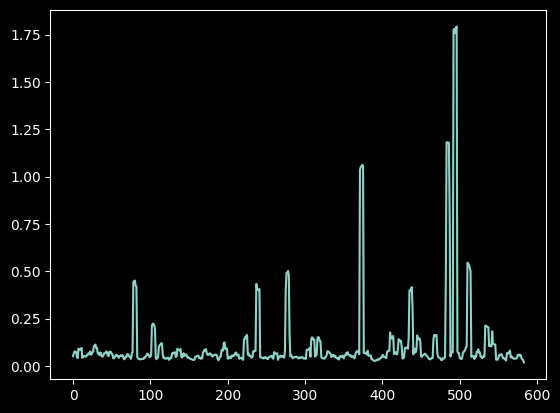

In [200]:
window = 5
smoothed = np.convolve(norm_errors, np.ones(window)/window, mode='same')
plt.plot(smoothed)

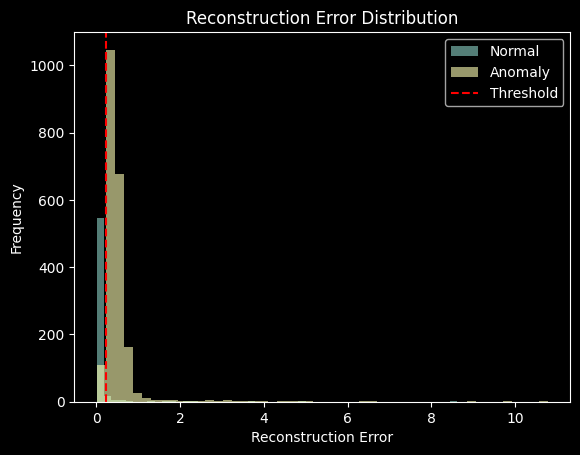

In [186]:
plt.hist(norm_errors, bins=50, alpha=0.6, label='Normal')
plt.hist(anm_errors, bins=50, alpha=0.6, label='Anomaly')
plt.axvline(threshold, color='red', linestyle='--', label='Threshold')
plt.legend()
plt.title('Reconstruction Error Distribution')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.show()